In [1]:
import yaml
from yaml.loader import SafeLoader
import numpy as np
from copy import deepcopy

In [2]:
import logging

logging.basicConfig(format='%(asctime)s %(levelname)-8s %(message)s',
                    filename='log.log',
                    filemode='w', 
                    encoding='utf-8', 
                    level=logging.DEBUG,
                    datefmt='%Y-%m-%d %H:%M:%S')

In [3]:
logging.info("read_yaml conversion started!")

In [4]:
# Open the file and load the file
with open('IEA-15-240-RWT_test.yaml') as f:
    data = yaml.load(f, Loader=SafeLoader)

In [5]:
print(data.keys())

dict_keys(['name', 'description', 'assembly', 'simulationparamter', 'environment', 'components', 'airfoils', 'materials', 'control', 'bos', 'costs'])


# Constant Parameters

In [6]:
scaling_blade = 1; 
scaling_tower = 1;
cos_msl       = np.array([0.0, 0.0, 0.0])                                                 # MSL position in global coordinate system

n_yaw         = np.array([[0, 0, 1]])                                                 # yaw rotation axis
n_tilt        = np.array([[0, 1, 0]])                                                # tilt rotation axis

flag_tower       = 1;                                                  # - tower on(1)/off(0)
flag_tower_aero  = 1;                                                  # - tower aero grid on(1)/off(0)
flag_tower_struc = 1;                                                  # - tower aero grid on(1)/off(0)

flag_blade       = 1;                                                  # - blades on(1)/off(0)
flag_blade_aero  = 1;                                                  # - blades aero grid on(1)/off(0)
flag_blade_struc = 1;                                                  # - blades structure mesh on(1)/off(0)

flag_foundation       = 1;                                             # - foundation on(1)/off(0)
flag_foundation_aero  = 1;                                             # - foundation aero grid on(1)/off(0)
flag_foundation_struc = 1;                                             # - foundation structure mesh on(1)/off(0)

flag_hub     = 1;                                                      # - hub on(1)/off(0)
flag_nacelle = 1;  

In [7]:
mspan = data["components"]["blade"]["DeSiO"]["uvlm"]["M_aero"]
print(f"mspan : {mspan}")

mspan : 50


In [8]:
jobname      = 'mesh_tests_blade'; 
if "jobname" in data.keys():
    strfilename = data["jobname"]
strfilename = jobname +'_pitch' + str(data["environment"]["pitch_angle"])+ '_vel' +str(data["environment"]["vinf"])

# Environmnet Conditions

In [9]:
yaw_angle = 0.0;
pitch_angle = 0.0;
if "environment" in data.keys():
    if "yaw_angle" in data["environment"].keys():
        yaw_angle = data["environment"]["yaw_angle"]
    if "pitch_angle" in data["environment"].keys():
        pitch_angle = data["environment"]["pitch_angle"]
fsi_radius_rbf = 0;
if 'fsi_radius_rbf' in data["simulationparamter"].keys():
    fsi_radius_rbf = data["simulationparamter"]["fsi_radius_rbf"];

In [10]:
from scipy.interpolate import interp1d
from math import pi, cos, sin

class Beam:
    def __init__(self,strName,model_beam, materials):
        
        self.strName = strName
        self.materials = materials
        # span wise discritization
        self.model_beam = model_beam
        self.M = model_beam["M_struc"]
        # initializing stiffness and mass matrix
        self.arr_stiff_matrix = np.zeros((self.M,21))
        self.arr_mass_matrix = np.zeros((self.M,6))
        self.O = np.zeros((self.M,1));
        
        # nodal natural coordinates in span-wise direction
        self.xhi_x  = np.arange(0,1 + 1/self.M,1/self.M)
        # print(f"xhi_x.shape : {self.xhi_x.shape}")
        
        # element natural coordinates in span-wise direction
        self.xhi_x_elem = (self.xhi_x[0:-1]+self.xhi_x[1:])/2
        # print(f"xhi_x_elem.shape : {self.xhi_x_elem.shape}")
        self.interpolate_ref_values()
        
        self.connectivity = np.zeros((self.M,3)) 
    def __repr__(self) -> str:
        return f'''Beam(M= {self.M}, arr_stiff_matrix = {self.arr_stiff_matrix}
                , arr_mass_matrix = {self.arr_mass_matrix}, 
                arr_xre_x = {self.arr_xre_x}, 
                arr_xre_y = {self.arr_xre_y},
                arr_xre_z = {self.arr_xre_z},
                arr_twist = {self.arr_twist},
                dissipation = {self.dissipation}
                )'''
    def ifassign(self,field, subkey, xq):
        """
            This function checks if the subkey is available in the field.keys
            if it does the it does linear interpolation between grid and values
            Inputs:
                field: dict
                subkey: str
                xq: querry points
        """
        if subkey in field.keys():
            x = field[subkey]["grid"]
            y = field[subkey]["values"]
            fun = interp1d(x,y)
            return fun(xq)
    def interpolate_cross_sectional(self):
        # if-statement according to type of surface cross-section
        if "blade" in self.strName:
            # interpolating along span-wise direction
            if 'six_x_six' in self.model_beam["elastic_properties_mb"]:
                x_el_phy = self.model_beam["elastic_properties_mb"]["six_x_six"]["stiff_matrix"]["grid"]
                
                self.model_beam["elastic_properties_mb"]["six_x_six"]["stiff_matrix"]["values"] = np.asarray(self.model_beam["elastic_properties_mb"]["six_x_six"]["stiff_matrix"]["values"])
                for i in range(21):
                    
                    
                    x_el_ref = self.model_beam["elastic_properties_mb"]["six_x_six"]["stiff_matrix"]["values"][:,i]
                    
                    el_model = interp1d(x_el_phy, x_el_ref)
                    self.arr_stiff_matrix[:,i] = el_model(self.xhi_x_elem)
                x_in_phy = self.model_beam["elastic_properties_mb"]["six_x_six"]["inertia_matrix"]["grid"]
                self.model_beam["elastic_properties_mb"]["six_x_six"]["inertia_matrix"]["values"] = np.asarray(self.model_beam["elastic_properties_mb"]["six_x_six"]["inertia_matrix"]["values"])
                for i in range(6):
                    x_in_ref = self.model_beam["elastic_properties_mb"]["six_x_six"]["inertia_matrix"]["values"][:,i]
                    in_model = interp1d(x_in_phy, x_in_ref)
                    self.arr_mass_matrix[:,i] = in_model(self.xhi_x_elem)
                self.dissipation = np.asarray([self.model_beam["dissipation"]["alpha_s"], self.model_beam["dissipation"]["alpha_v"]])
            else:
                self.arr_EA  = np.zeros((self.M,1)); 
                self.arr_GA1 = np.zeros((self.M,1)); 
                self.arr_GA2 = np.zeros((self.M,1));
                self.arr_EI1 = np.zeros((self.M,1)); 
                self.arr_EI2 = np.zeros((self.M,1)); 
                self.arr_GI3 = np.zeros((self.M,1));
                self.arr_ES1 = np.zeros((self.M,1)); 
                self.arr_ES2 = np.zeros((self.M,1)); 
                self.arr_EI12 = np.zeros((self.M,1));
                self.arr_GS1 = np.zeros((self.M,1)); 
                self.arr_GS2 = np.zeros((self.M,1));

                self.arr_rhoA  = np.zeros((self.M,1)); self.arr_rhoI1 = np.zeros((self.M,1)); self.arr_rhoI2  = np.zeros((self.M,1));
                self.arr_rhoS1 = np.zeros((self.M,1)); self.arr_rhoS2 = np.zeros((self.M,1)); self.arr_rhoI12 = np.zeros((self.M,1));

                if 'EA' in self.model_beam["elastic_properties_mb"].keys():
                    x = self.model_beam["elastic_properties_mb"]["EA"]["grid"]
                    y = self.model_beam["elastic_properties_mb"]["EA"]["values"]
                    fun = interp1d(x,y)
                    self.arr_EA   = fun(self.xhi_x_elem);


                
                self.arr_GA1  = self.ifassign(self.model_beam["elastic_properties_mb"],'GA1',self.xhi_x_elem)
                self.arr_GA2  = self.ifassign(self.model_beam["elastic_properties_mb"],'GA2',self.xhi_x_elem)
                self.arr_EI1  = self.ifassign(self.model_beam["elastic_properties_mb"],'EI1',self.xhi_x_elem)
                self.arr_EI2  = self.ifassign(self.model_beam["elastic_properties_mb"],'EI2',self.xhi_x_elem)
                self.arr_GI3  = self.ifassign(self.model_beam["elastic_properties_mb"],'GI3',self.xhi_x_elem)
                self.arr_ES1  = self.ifassign(self.model_beam["elastic_properties_mb"],'ES1',self.xhi_x_elem)
                self.arr_ES2  = self.ifassign(self.model_beam["elastic_properties_mb"],'ES2',self.xhi_x_elem)
                self.arr_GS1  = self.ifassign(self.model_beam["elastic_properties_mb"],'GS1',self.xhi_x_elem)
                self.arr_GS2  = self.ifassign(self.model_beam["elastic_properties_mb"],'GS2',self.xhi_x_elem)
                self.arr_EI12  = self.ifassign(self.model_beam["elastic_properties_mb"],'EI12',self.xhi_x_elem)
                self.arr_rhoA  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoA',self.xhi_x_elem)
                self.arr_rhoI1  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoI1',self.xhi_x_elem)
                self.arr_rhoI2  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoI2',self.xhi_x_elem)
                self.arr_rhoS1  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoS1',self.xhi_x_elem)
                self.arr_rhoS2  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoS2',self.xhi_x_elem)
                self.arr_rhoI12  = self.ifassign(self.model_beam["elastic_properties_mb"],'rhoI12',self.xhi_x_elem)

                
                # GA1 GA2 EA EI1 EI2 GI3 0 0 0 GS2 -GS1 0 0 0 0 0 ES1 -EI12 -ES2 0 0
                self.arr_stiff_matrix[:,:] = [self.arr_GA1, self.arr_GA2, self.arr_EA, self.arr_EI1, self.arr_EI2, self.arr_GI3, \
                                                self.O, self.O, self.O, self.arr_GS2, -self.arr_GS1, self.O, self.O, self.O, self.O, self.O, self.arr_ES1, -self.arr_EI12,\
                                              -self.arr_ES2, self.O, self.O];

                # rhoA, rhoI2, rhoI1, rhoI12, rhoS1, rhoS2
                self.arr_mass_matrix[:,:]   = [self.arr_rhoA, self.arr_rhoI2, self.arr_rhoI1, self.arr_rhoI12, self.arr_rhoS1, self.arr_rhoS2];
                self.dissipation         = np.asarry([self.model_beam["dissipation"]["alpha_s"], self.model_beam["dissipation"]["alpha_v"]])
        
        if 'pipe' in self.strName:
            # interpolating cross-section properties along span-wise direction
            E = 0.0; G = 0.0; rho = 0.0;

            # self.materials is the list of dictionaries of cross-section properties
            if 'material' in self.model_beam.keys():
                strmaterial = self.model_beam["material"];
                for i in range(len( self.materials )):
                    if strmaterial in self.materials[i]["name"]:
                        if len(self.materials[i]["name"]) == len(strmaterial):
                            E   = self.materials[i]["E"]
                            nu  = self.materials[i]["nu"]
                            rho = self.materials[i]["rho"]
                            G   = E/(2.0*(1.0+nu))




            if 'elastic_properties_mb' in self.model_beam.keys():
                E   = self.model_beam["elastic_properties_mb"]["E"];
                G   = E/(2.0*(1+self.model_beam["elastic_properties_mb"]["nu"]));
                rho = self.model_beam["elastic_properties_mb"]["rho"];


            k1  = 1.0;
            k2  = 1.0;
            if 'shear_factor' in self.model_beam.keys():
                k1 = self.model_beam["shear_factor"]["k1"];
                k2 = self.model_beam["shear_factor"]["k2"];


            self.arr_outer_diameter = self.ifassign(self.model_beam,"outer_diameter",self.xhi_x_elem)
            
            self.arr_thickness      = self.ifassign(self.model_beam,"thickness",self.xhi_x_elem)
            self.arr_EA             = E*pi/4*(self.arr_outer_diameter**2 - (self.arr_outer_diameter-2*self.arr_thickness)**2);
            self.arr_GA1            = k1*G*pi/4*(self.arr_outer_diameter**2 - (self.arr_outer_diameter-2*self.arr_thickness)**2);
            self.arr_GA2            = k2*G*pi/4*(self.arr_outer_diameter**2 - (self.arr_outer_diameter-2*self.arr_thickness)**2);
            self.arr_EI1            = E*pi/64*(self.arr_outer_diameter**4 - (self.arr_outer_diameter-2*self.arr_thickness)**4);
            self.arr_EI2            = E*pi/64*(self.arr_outer_diameter**4 - (self.arr_outer_diameter-2*self.arr_thickness)**4);
            self.arr_GI3            = G*pi/32*(self.arr_outer_diameter**4 - (self.arr_outer_diameter-2*self.arr_thickness)**4);
            self.arr_ES1            = self.arr_EA*0;
            self.arr_ES2            = self.arr_EA*0;
            self.arr_GS2            = self.arr_EA*0;
            self.arr_GS1            = self.arr_EA*0;
            self.arr_EI12           = self.arr_EA*0;

            self.arr_rhoA           = rho*pi/4*(self.arr_outer_diameter**2 - (self.arr_outer_diameter-2*self.arr_thickness)**2);
            self.arr_rhoI1          = rho*pi/64*(self.arr_outer_diameter**4 - (self.arr_outer_diameter-2*self.arr_thickness)**4);
            self.arr_rhoI2          = rho*pi/64*(self.arr_outer_diameter**4 - (self.arr_outer_diameter-2*self.arr_thickness)**4);
            self.arr_rhoI12         = self.arr_rhoA*0;
            self.arr_rhoS1          = self.arr_rhoA*0;
            self.arr_rhoS2          = self.arr_rhoA*0;

            # print(type(self.arr_GA1), self.arr_GA1.shape)
            # print(type(self.arr_GA2), self.arr_GA2.shape)
            # print(type(self.arr_EA), self.arr_EA.shape)
            # print(type(self.arr_EI1), self.arr_EI1.shape)
            # print(type(self.arr_EI2), self.arr_EI2.shape)
            # print(type(self.arr_GI3), self.arr_GI3.shape)
            # print(type(self.arr_ES1), self.arr_ES1.shape)
            # print(type(self.arr_ES2), self.arr_ES2.shape)
            # print(type(self.arr_GS1), self.arr_GS1.shape)
            # print(type(self.arr_GS2), self.arr_GS2.shape)
            # print(type(self.arr_EI12), self.arr_EI12.shape)
            # print(type(self.O), self.O.shape)

            O = self.O[:,0]
            # GA1 GA2 EA EI1 EI2 GI3 0 0 0 GS2 -GS1 0 0 0 0 0 ES1 -EI12 -ES2 0 0
            self.arr_stiff_matrix[:,:] = np.vstack([self.arr_GA1, self.arr_GA2, self.arr_EA, self.arr_EI1, self.arr_EI2, self.arr_GI3, \
                                            O, O, O, \
                                                self.arr_GS2, -self.arr_GS1, \
                                                    O, O, O, O, O, \
                                                        self.arr_ES1, -self.arr_EI12, -self.arr_ES2, \
                                                             O, O]).T

            self.arr_mass_matrix[:,:] = np.vstack([self.arr_rhoA, self.arr_rhoI2, \
                                                    self.arr_rhoI1, self.arr_rhoI12, \
                                                        self.arr_rhoS1, self.arr_rhoS2]).T
            self.dissipation       = np.asarray([ self.model_beam["dissipation"]["alpha_s"], self.model_beam["dissipation"]["alpha_v"]])                  
        
    def interpolate_ref_values(self):
        x_phy = self.model_beam["reference_axis"]["x"]["grid"]
        y_phy = self.model_beam["reference_axis"]["y"]["grid"]
        z_phy = self.model_beam["reference_axis"]["z"]["grid"]
        x_ref = self.model_beam["reference_axis"]["x"]["values"]
        y_ref = self.model_beam["reference_axis"]["y"]["values"]
        z_ref = self.model_beam["reference_axis"]["z"]["values"]
        fx = interp1d(x_phy, x_ref)
        fy = interp1d(y_phy, y_ref)
        fz = interp1d(z_phy, z_ref)
        self.arr_xre_x = fx(self.xhi_x)
        self.arr_xre_y = fy(self.xhi_x)
        self.arr_xre_z = fz(self.xhi_x)
        
        # interpolating twist angle according to span-wise discretization
        if 'twist' in self.model_beam.keys():
            phi_phy = self.model_beam["twist"]["grid"]
            phi_ref = self.model_beam["twist"]["values"]
            phi_interp = interp1d(phi_phy, phi_ref)
            self.arr_twist = phi_interp(self.xhi_x);
        self.interpolate_cross_sectional()
        
        
def fun_extract_beam_data(strName,model_beam,materials):
    """
         input:
           strName - type of surface of (airfoil) cross-section
           model - component beam object specified in WindIO
           materials - material data specified in WindIO
           scale_opt - scaling factor for scaling in longitudinal direction (optional input)
         output:
             beam - beam object containing coordinates and connectivity for creating structural mesh
    """
  
    # span-wise discretization
    beam = Beam(strName,model_beam,materials)
    return beam
# tower_Struc  = fun_get_beam_model('pipe',data["components"]["tower"]["DeSiO"]["beam"],
#                                       data["materials"],scaling_tower);      # create structural mesh


In [11]:
def fun_get_beam_model(strName,model,materials,scale_opt=1):
    """
         input:
           strName - type of surface of (airfoil) cross-section
           model - component beam object specified in WindIO
           materials - material data specified in WindIO
           scale_opt - scaling factor for scaling in longitudinal direction (optional input)
         output:
           beam - beam object containing coordinates and connectivity for creating structural mesh
    """
    beam  = fun_extract_beam_data(strName,model,materials)
    # print(beam)
    scale = scale_opt
    # twist angle around pitch axis
    arr_twist = np.zeros((beam.M+1,1))
    if 'twist' in model.keys():
        arr_twist = -beam.arr_twist;


    # reference axis
    arr_xre   = np.vstack([beam.arr_xre_x, \
                            beam.arr_xre_y, \
                            beam.arr_xre_z*scale]).T

    # beam position and director coordinates of the reference axis
    beam.arr_coordinates = [];
    for i in range(model["M_struc"]+1):

        # save the old directors from the previous segment
        if i == 0:
            d1_old = np.asarray([[1], [0], [0]]);
            d2_old = np.asarray([[0], [1], [0]]);
            d3_old = np.asarray([[0], [0], [1]]);
            alpha_old = 0;
        else:

            alpha_old = arr_twist[i-1];
            d1_old = d1;
            d2_old = d2;
            d3_old = d3;

        assert d1_old.ndim == 2, "d1 should have 2 dim array"
        assert d2_old.ndim == 2, "d2 should have 2 dim array"
        assert d3_old.ndim == 2, "d3 should have 2 dim array"
        # compute the new 3-director
        n3 = np.zeros((3, 1));   # the current connection vector
        if i == model["M_struc"]:
            n3[:,0] = arr_xre[i,:] - arr_xre[i-1,:];  # exeption at last node: connection interpolated backwards
        else:
            n3[:,0] = arr_xre[i+1,:] - arr_xre[i,:];  # usual case: connection interpolated forward

        d3 = n3/np.linalg.norm(n3);   # 3-director as normed connection vector

        # compute the angle between old and new 3-director and the
        # corresponding rotation axis
        theta = np.arccos(np.dot(d3_old.flatten(), d3.flatten()));   # rotation angle
        # if i == model["M_struc"]:
        #     print(f"theta = {theta}")
        # compute the rotation axis for the computation with the new
        # 3-director if the rotation angle is not very small
        if theta <= 1e-6 or np.isnan(theta):   # special case (for the last segment): the old and new director are very similar --> then just use one of the old directors as 
            rot_matrix = np.eye(3);
        else:
            temp = np.cross(d3_old.flatten(), d3.flatten())
            rot_axis = temp/np.linalg.norm(temp);   # direction vector of the rotation axis
            u_x = rot_axis[0];  # 1-component of the rotation axis
            u_y = rot_axis[1];  # 2-component of the rotation axis
            u_z = rot_axis[2];  # 3-component of the rotation axis

        # compute the rotation matrix
            rot_matrix = np.asarray([
            [cos(theta) + u_x**2*(1-cos(theta)),          u_x*u_y*(1-cos(theta)) - u_z*sin(theta),	u_x*u_z*(1-cos(theta)) + u_y*sin(theta)],
            [u_y*u_x*(1-cos(theta)) + u_z * sin(theta),    cos(theta) + u_y**2*(1-cos(theta)),          u_y*u_z*(1-cos(theta)) - u_x*sin(theta)],
            [u_z*u_x*(1-cos(theta)) - u_y*sin(theta),    u_z*u_y*(1-cos(theta)) + u_x*sin(theta),    cos(theta) + u_z**2*(1-cos(theta))]
                    ]);


        # rotate the directors to get the new COS (without twist)
        d3_check = rot_matrix @ d3_old;
        d3_diff = d3 - d3_check;
        if np.linalg.norm(d3_diff)>1e-10:
            print('ERROR: rotation does not work as inted');
            print(d3_old);
            print(d3);
            print(d3_check);
            return

        d2_noTw = rot_matrix @ d2_old
        d1_noTw = rot_matrix @ d1_old

        # include the twist
        alpha_tw = arr_twist[i] - alpha_old;   # current twist angle

        # rotation axis for the twist rotation: the current 3-director
        rot_axis = d3;
        u_x = float(rot_axis[0])  # 1-component of the rotation axis
        u_y = float(rot_axis[1])  # 2-component of the rotation axis
        u_z = float(rot_axis[2])  # 3-component of the rotation axis

        # compute the rotation matrix for the twist rotation
        rot_matrix_Tw = np.asarray([
        [cos(alpha_tw) + u_x**2*(1-cos(alpha_tw)),          u_x*u_y*(1-cos(alpha_tw)) - u_z*sin(alpha_tw),	u_x*u_z*(1-cos(alpha_tw)) + u_y*sin(alpha_tw)],
        [u_y*u_x*(1-cos(alpha_tw)) + u_z*sin(alpha_tw),	cos(alpha_tw) + u_y**2*(1-cos(alpha_tw)),          u_y*u_z*(1-cos(alpha_tw)) - u_x*sin(alpha_tw)],
        [u_z*u_x*(1-cos(alpha_tw)) - u_y*sin(alpha_tw),    u_z*u_y*(1-cos(alpha_tw)) + u_x*sin(alpha_tw),    cos(alpha_tw) + u_z**2*(1-cos(alpha_tw))]
        ]);

        # compute the new directors
        d1 = rot_matrix_Tw @ d1_noTw
        d2 = rot_matrix_Tw @ d2_noTw

        # transpose the vectors for output
#         d1 = d1';
#         d2 = d2';
#         d3 = d3';

        # write the computed current director and reference point to the output-array
        temp = np.expand_dims(arr_xre[i,:],0)
        temp = np.hstack([temp,d1.T,d2.T,d3.T])
        # print(f"temp.shape = {temp.shape}")
        beam.arr_coordinates.append(temp[0,:])
        



    beam.arr_coordinates = np.asarray(beam.arr_coordinates)
    # beam connectivities
    for i in range(model["M_struc"]):
        beam.connectivity[i,:] = [i,i+1,i];
    return beam


In [12]:
def if_assign(field, subkey, xq, sep_values=None):
    """
        This function checks if the subkey is available in the field.keys
        if it does the it does linear interpolation between grid and values
        Inputs:
            field: dict
            subkey: str
            xq: querry points
            sep_values: If this is defined it will treated as y for the interpolation
    """
    if sep_values is None:
        if subkey in field.keys():
            x = field[subkey]["grid"]
            y = field[subkey]["values"]
            fun = interp1d(x,y)
            return fun(xq)
    else:
        if subkey in field.keys():
            x = field[subkey]["grid"]
            y = sep_values
            fun = interp1d(x,y)
            return fun(xq)
def interp1D(array, xq):
    x = array[:,0]
    y = array[:,1]
    fun = interp1d(x,y)
    return fun(xq)
class UVLM:
    def __init__(self, strName,model_uvlm,airfoils):
        # span-wise and chord-wise discretization
        self.M = model_uvlm["M_aero"]
        self.N = model_uvlm["N_aero"]
        
        # natural coordinates of span-and chord-wise discretization
        self.xhi_x  = np.arange(0,1 + 1/self.M,1/self.M) # span-wise
        self.xhi_y_c  = np.arange(0,1 + 1/self.N,1/self.N) # chord-wise
        
        
    

        nbr             = 0;                    # number of blade root cross-section
        arr_inz_airfoil = [];                   # index array for locating airfoils in span-wise direction
        
        # interpolating coordinates of reference axis according to span-wise discretization
        self.arr_xre_x = if_assign(model_uvlm["reference_axis"], "x", self.xhi_x)
        self.arr_xre_y = if_assign(model_uvlm["reference_axis"], "y", self.xhi_x)
        self.arr_xre_z = if_assign(model_uvlm["reference_axis"], "z", self.xhi_x)
        arr_val_c = []
        arr_val_w = []
        # if-statement according to type of surface cross-section
        if "blade" in strName:
            self.airfoil = model_uvlm["airfoil_position"]
            nbr              = model_uvlm["blade_root_position"]

            # interpolating chord length in span-wise direction
            self.arr_c = if_assign(model_uvlm, "chord", self.xhi_x)

            # interpolating twist angle according to span-wise discretization
            self.arr_twist = np.zeros((self.M,1))
            
            self.arr_twist = if_assign(model_uvlm, "twist", self.xhi_x)
            
            # interpolating airfoil in span-wise direction. This is important
            # to identify the blade root and blade's lifting surfaces
            airfoil_grid    = self.airfoil["grid"]
            # TODO:
#             airfoil_values  = [1:length(uvlm_obj.airfoil.grid)]
#             print(self.airfoil)
#             print('*'*80)
#             print(len(airfoils))
#             print(airfoils[0].keys())
            airfoil_values  = range(len(self.airfoil["grid"]))
            fun = interp1d(airfoil_grid,airfoil_values)
            arr_inz_airfoil = np.fix(fun(self.xhi_x))

            arr_pitch_ax = np.ones((self.M+1,1))*1.0;
            self.arr_pitch_ax = if_assign(model_uvlm, "pitch_axis",self.xhi_x)
            
            # natural coordinates of chord-wise discretization for whole
            # surface of cross-section
            xhi_y_w = self.xhi_y_c;
        elif "pipe" in strName:
            logging.debug("UVLM class:\nInside pipe:")
            # interpolating chord length in span-wise direction
            temp = np.asarray(model_uvlm["outer_diameter"]["values"]) \
                - np.asarray(model_uvlm["thickness"]["values"])
            logging.debug('model_uvlm["outer_diameter"]["values"]: ' + str(model_uvlm["outer_diameter"]["values"]) )
            logging.debug('model_uvlm["thickness"]["values"]: ' + str(model_uvlm["thickness"]["values"]) )
            self.arr_c          = if_assign(model_uvlm,
                                            "outer_diameter",
                                            self.xhi_x, # these are query points
                                            temp # this is y for interpolation
                                           );
            self.arr_twist      = np.zeros((self.M+1,1)) # zero twist
            self.arr_pitch_ax   = np.ones((self.M+1,1))*0.5; # location of pitch axis
            self.airfoil = {}
            self.airfoil["labels"] = ['circular','circular']  # artificial "airfoil" sections for pipe
            self.airfoil["grid"]   = [0.0, 1.0];               # artificial "airfoil" sections grid for pipe

            # mesh discretization around circular cross-section
            temp = np.linspace(0,np.pi, self.N+1)
            xhi_y_w = 0.5*(1-np.cos(temp))
        # loop over airfoils in the model to calculate coordinates of
        # cross-section surfaces
        for i in range(len(self.airfoil["labels"])):
            airfoil_name = self.airfoil["labels"][i]

            # searching current airfoil from airfoil-list
            for j in range(len(airfoils)):
                if len(airfoils) == 1:
                    if airfoil_name in airfoils[j]["name"]:
                        airfoilj = airfoils;
                        break

                else:
                    if airfoil_name in airfoils[j]["name"]  :
                        airfoilj = airfoils[j]
                        break




            # extracting coordinates for upper and lower airfoil 
            airfoil_coord = np.vstack([airfoilj["coordinates"]["x"],airfoilj["coordinates"]["y"]]).T
            logging.debug(f"airfoil_coord.shape: {airfoil_coord.shape}")
            inz0 = np.nonzero(airfoil_coord[:,0]==0) 
            inz0 = inz0[0][0] + 1
            logging.debug(f"inz0: {inz0}")
            airfoil_coord_u = airfoil_coord[:inz0,:]; 
            inzsort = np.argsort(airfoil_coord_u[:,0])
            airfoil_coord_u = airfoil_coord_u[inzsort,:]
            airfoil_coord_l = airfoil_coord[inz0-1:,:]; 
            inzsort = np.argsort(airfoil_coord_l[:,0]) 
            airfoil_coord_l = airfoil_coord_l[inzsort,:]

            # interpolating values in airfoil thickness direction according to
            # discretization in chord-wise direction to calculate camber
            # surface coordinates
#             print("airfoil_coord_u: ",airfoil_coord_u)
            xhi_airf_u = interp1D(airfoil_coord_u,self.xhi_y_c);
            xhi_airf_l = interp1D(airfoil_coord_l,self.xhi_y_c);
            # coordinates of camber surface
#             print(xhi_airf_u.shape, xhi_airf_l.shape)
            xhi_airf_c = (xhi_airf_u + xhi_airf_l)/2;

            # interpolating values in airfoil thickness direction according to
            # discretization in chord-wise direction to calculate whole
            # cross-section surface coordinates
            xhi_airf_u = interp1D(airfoil_coord_u,xhi_y_w);
            xhi_airf_l = interp1D(airfoil_coord_l,xhi_y_w);
            # coordinates of whole cross-section surface
            xhi_airf_w = np.append(np.append(xhi_airf_u[:-1],(xhi_airf_u[-1] + xhi_airf_l[-1])/2),xhi_airf_l[-2::-1])
#             print("xhi_airf_w.shape: ",xhi_airf_w.shape)
            
            # if-statement to detect, if blade root s. In case blade root
            # , switching from whole surface to camber surface
            if i == nbr+1:
                if nbr != 0:
                    xhi_airf_w = np.append(xhi_airf_c[:-1],xhi_airf_c[::-1])
#                     print("inside: xhi_airf_w.shape: ",xhi_airf_w.shape)



#             print("xhi_airf_c.shape :", xhi_airf_c.shape)
            arr_val_c.append( xhi_airf_c)      # camber surface coordinates 
            arr_val_w.append( xhi_airf_w) # whole surface coordinates
        arr_val_c = np.asarray(arr_val_c).T
        arr_val_w = np.asarray(arr_val_w).T
        

        # interpolating camber surface coordinates in span-wise direction 
        arr_xhi_airf_c = np.zeros((self.xhi_x.size, arr_val_c.shape[0]))
        for i in range(arr_val_c.shape[0]):
            x = np.asarray(self.airfoil["grid"])
            y = arr_val_c[i,:]
            # print("line 165: (x.shape, y.shape): ",x.shape, y.shape)
            fun = interp1d(x,y)
            arr_val = fun(self.xhi_x)
            arr_xhi_airf_c[:,i] = arr_val


        # interpolating whole surface coordinates in span-wise direction
        arr_xhi_airf_w =  np.zeros((self.xhi_x.size, arr_val_w.shape[0]))
        for i in range(arr_val_w.shape[0]):
            x = self.airfoil["grid"]
            y = arr_val_w[i,:]
            fun = interp1d(x,y)
            arr_val = fun(self.xhi_x)
            
            arr_xhi_airf_w[:,i] = arr_val


        if nbr!=0:
            inz  = np.nonzero(arr_inz_airfoil<=nbr)
            inz = inz[0]
            temp_coo = arr_xhi_airf_c[inz[-1]+1,:]
            arr_xhi_airf_w[inz[-1]+1,:] = np.append(temp_coo,temp_coo[-2::-1])
        self.arr_xhi_airf_c  = arr_xhi_airf_c;
        self.arr_xhi_airf_w  = arr_xhi_airf_w;
        self.xhi_y_w         = xhi_y_w;
        self.arr_xhi_x       = self.xhi_x
        self.nbr             = nbr;
        self.arr_inz_airfoil = arr_inz_airfoil;

        # elements in x (span) and y (chord) direction
        mx = len(self.arr_xhi_x) - 1
        my = self.N
        max_dim = self.arr_c.shape[0]
        dim_w = max_dim*(2*my+1)
        dim_c = max_dim*(my+1)
        self.X_W = np.zeros((dim_w,3))
        self.X_C = np.zeros((dim_c,3))
        

            
            
    
    
        
def fun_extract_uvlm_data(strName,model_uvlm,airfoils):
    """   
     input:
       strName - type of surface of (airfoil) cross-section
       model - component uvlm object specified in WindIO
       airfoils - airfoil data specified in WindIO
     output:
         uvlm_ob - uvlm object containing coordinates and connectivity for creating aerodynamic grid
     =================================================================================================================
    """
    uvlm_ob = UVLM(strName,model_uvlm,airfoils)
    # for debugging
#     for var in vars(uvlm_ob):
#         print(f"{var} : ",getattr(uvlm_ob, var))
#         print('*'*80)
#         print('*'*80)
#         print('*'*80)
    return uvlm_ob


In [13]:
def fun_get_uvlm_geometry(strName,model,airfoils,scale_opt=1):
    """
         Input:
           airfoils - airfoil data specified in WindIO
           scale_opt - scaling factor for scaling in longitudinal direction (optional input)
         output:
             uvlm_ob - uvlm object containing coordinates and connectivity for creating aerodynamic grid
         =================================================================================================================

    """
    # extracting uvlm data from WindIO
    uvlm_ob = fun_extract_uvlm_data(strName,model,airfoils)
    
    # elements in x (span) and y (chord) direction
    mx =  len(uvlm_ob.arr_xhi_x)-1; 
    my =  uvlm_ob.N;
    
    # natural coordinates in chord-wise direction of cross-section
    xhi_y_c   = uvlm_ob.xhi_y_c;                                            # camber surface
    xhi_y_w   = np.append(uvlm_ob.xhi_y_w, uvlm_ob.xhi_y_w[-2::-1])       # whole surface of cross-section
    
    # some extracted geometry arrays interpolated to spatial discretization
    arr_chord      = uvlm_ob.arr_c;                                         # chord length c
    arr_pitch_ax   = uvlm_ob.arr_pitch_ax;                                  # position of pitch axis in c
    arr_xhi_airf_c = uvlm_ob.arr_xhi_airf_c;                                # camber surface of (ariofoil) cross-section in c
    arr_xhi_airf_w = uvlm_ob.arr_xhi_airf_w;                                # whole surface of (ariofoil) cross-section in c
    arr_twist      = -uvlm_ob.arr_twist;                                    # twist angle around pitch axis
    arr_xre        = np.vstack([uvlm_ob.arr_xre_x,uvlm_ob.arr_xre_y, uvlm_ob.arr_xre_z*scale_opt]).T       # reference axis
    arr_coordinates = np.zeros((mx+1,12))
    # position and director coordinates of the reference axis
    for i in range(mx+1):
        # save the old directors from the previous segment
        if i == 0:
            d1_old = np.asarray([[1], [0], [0]])
            d2_old = np.asarray([[0], [1], [0]])
            d3_old = np.asarray([[0], [0], [1]])
            alpha_old = 0;
        else:
            d1_old = d1   # transposed because they were transposed for the output
            d2_old = d2
            d3_old = d3
            alpha_old = arr_twist[i-1]


        # compute the new 3-director
        n3 = np.zeros((3, 1))   # the current connection vector
        if i == mx:
            n3[:,0] = arr_xre[i,:] - arr_xre[i-1,:];  # exeption at last node: connection interpolated backwards
        else:
            n3[:,0] = arr_xre[i+1,:] - arr_xre[i,:];  # usual case: connection interpolated forward

        d3 = n3/np.linalg.norm(n3);   # 3-director as normed connection vector

        # compute the angle between old and new 3-director and the
        # corresponding rotation axis
        theta = np.arccos(np.dot(d3_old[:,0], d3[:,0]));   # rotation angle
        #         if i == model.M_struc+1
        #             print('rotation angle:');
        #             print(theta);
        #         
        
        if theta <= 1e-6 or np.isnan(theta):   # special case (for the last segment): the old and new director are very similar --> then just use one of the old directors as 
            rot_matrix = np.eye(3)
        else:
            temp = np.cross(d3_old[:,0], d3[:,0])
            rot_axis = temp/np.linalg.norm(temp);   # direction vector of the rotation axis
            u_x = float(rot_axis[0])  # 1-component of the rotation axis
            u_y = float(rot_axis[1])  # 2-component of the rotation axis
            u_z = float(rot_axis[2])  # 3-component of the rotation axis
            
        #             print(rot_axis);
        #         if i == model.M_struc+1
        #             print('rotation axis:');
        #             print(rot_axis);
        #         
        # compute the rotation matrix
            rot_matrix = [
            [cos(theta) + u_x**2*(1-cos(theta)),          u_x*u_y*(1-cos(theta)) - u_z*sin(theta),	u_x*u_z*(1-cos(theta)) + u_y*sin(theta)],
            [u_y*u_x*(1-cos(theta)) + u_z*sin(theta),	cos(theta) + u_y**2*(1-cos(theta)),          u_y*u_z*(1-cos(theta)) - u_x*sin(theta)],
            [u_z*u_x*(1-cos(theta)) - u_y*sin(theta),    u_z*u_y*(1-cos(theta)) + u_x*sin(theta),    cos(theta) + u_z**2*(1-cos(theta))]]
            rot_matrix = np.asarray(rot_matrix)

        #         print(rot_matrix);

        #         if i == model.M_struc+1
        #             print('rotation matrix:');
        #             print(rot_matrix);
        #         

        # rotate the directors to get the new COS (without twist)
        d3_check = np.matmul(rot_matrix, d3_old);
        d3_diff = d3 - d3_check;
        if np.linalg.norm(d3_diff)>1e-10:
            print('ERROR: rotation does not work as inteded');
            print(d3_old);
            print(d3);
            print(d3_check);
            return

        d2_noTw = rot_matrix @ d2_old
        d1_noTw = rot_matrix @ d1_old

        # include the twist
        alpha_tw = arr_twist[i] - alpha_old;   # current twist angle

        # rotation axis for the twist rotation: the current 3-director
        rot_axis = d3
        u_x = float(rot_axis[0])  # 1-component of the rotation axis
        u_y = float(rot_axis[1])  # 2-component of the rotation axis
        u_z = float(rot_axis[2])  # 3-component of the rotation axis

        # compute the rotation matrix for the twist rotation
        rot_matrix_Tw = [
        [cos(alpha_tw) + u_x**2*(1-cos(alpha_tw)),          u_x*u_y*(1-cos(alpha_tw)) - u_z*sin(alpha_tw),	u_x*u_z*(1-cos(alpha_tw)) + u_y*sin(alpha_tw)],
        [u_y*u_x*(1-cos(alpha_tw)) + u_z*sin(alpha_tw),	cos(alpha_tw) + u_y**2*(1-cos(alpha_tw)),          u_y*u_z*(1-cos(alpha_tw)) - u_x*sin(alpha_tw)],
        [u_z*u_x*(1-cos(alpha_tw)) - u_y*sin(alpha_tw),    u_z*u_y*(1-cos(alpha_tw)) + u_x*sin(alpha_tw),    cos(alpha_tw) + u_z**2*(1-cos(alpha_tw))]]
        rot_matrix_Tw = np.asarray(rot_matrix_Tw)

        # print(f'i={i}, d1_noTw = {d1_noTw}')
        # print(f'i={i}, d1_noTw = {d2_noTw}')
        # compute the new directors
        d1 = rot_matrix_Tw @ d1_noTw
        d2 = rot_matrix_Tw @ d2_noTw

        # transpose the vectors for output
        

        # write the computed current director and reference point to the output-array
        arr_coordinates[i,:] = np.hstack([arr_xre[i,:],d1[:,0],d2[:,0],d3[:,0]])
    
    
    # calculating aerodynamic grid for DeSiO-Aero on the reference axis
    d10 = np.asarray([[1],[0],[0]] )
    d20 = np.asarray([[0],[1],[0]])
    d30 = np.asarray([[0],[0],[1]])
    for i_l in range(arr_coordinates.shape[0]):
        
        # reference position and director of/at center line
        xcenter = arr_coordinates[i_l:i_l+1,:3].T 
        d1 = arr_coordinates[i_l:i_l+1,3:6].T 
        d2 = arr_coordinates[i_l:i_l+1,6:9].T 
        d3 = arr_coordinates[i_l:i_l+1,9:12].T

        # rotation matrix for cross section orientation
        R_t = d3@d30.T + d2@d20.T + d1@d10.T
        
        # chord length and location of pitch axis
        c        = arr_chord[i_l] 
        xhi_p_ax = arr_pitch_ax[i_l]
        xhi_pn   = np.asarray([[0],[xhi_p_ax],[0]])

        # print(f'xcenter={xcenter, xcenter.shape}, xhi_p_ax={xhi_p_ax}, xhi_pn= {xhi_pn, xhi_pn.shape}, c={c}')
        # print(f'R_t={R_t}')
        # print(f'd1={d1,d1.shape}')
        # print(f'd2={d2, d2.shape}')
        # print(f'd3={d3, d3.shape}')
        
        # coordinates of whole cross-section
        dim_v = len(xhi_y_w)
        xcO = np.zeros((3,dim_v)); 
        xhi_pnO = np.zeros((3,dim_v))
        O              = np.ones((3,dim_v)) 
        xcO[:3,:]      = np.asarray([xcenter[0]*O[0,:],      xcenter[1]*O[1,:],  xcenter[2]*O[2,:]])
        xhi_pnO[:3,:]  = np.asarray([xhi_pn[0]*O[0,:],       xhi_pn[1]*O[1,:],   xhi_pn[2]*O[2,:]])
        xhi_airf_w     = np.asarray([arr_xhi_airf_w[i_l,:],  xhi_y_w,            0*O[2,:]])
        x_airf_w       = np.asarray([xhi_airf_w[0,:]*c,      xhi_airf_w[1,:]*c,  0*O[2,:]])
        
        # print(f'xcO={xcO, xcO.shape}')
        # print(f'xhi_pnO={xhi_pnO, xhi_pnO.shape}')
        # print(f'x_airf_w={x_airf_w, x_airf_w.shape}')
        # print(f'xhi_airf_w={xhi_airf_w, xhi_airf_w.shape}')


        # rotation of cross-section around pitch axis and recalcuating profile 
        # to middle axis (middle axis is on location of pitch axis)
        xp_w =  (R_t @ (x_airf_w - xhi_pnO*c)) + xcO 
        
        # print(f'xp_w={xp_w, xp_w.shape}')

        # coordinates of camber line
        dim_v = len(xhi_y_c)
        xcO = np.zeros((3,dim_v)); 
        xhi_pnO = np.zeros((3,dim_v))
        O              = np.ones((3,dim_v)) 
        xcO[:3,:]      = np.asarray([xcenter[0]*O[0,:],          xcenter[1]*O[1,:],         xcenter[2]*O[2,:]])
        xhi_pnO[:3,:]  = np.asarray([xhi_pn[0]*O[0,:],           xhi_pn[1]*O[1,:],          xhi_pn[2]*O[2,:]])
        xhi_airf_c     = np.asarray([arr_xhi_airf_c[i_l,:],      xhi_y_c,                   0*O[2,:]])
        x_airf_c       = np.asarray([xhi_airf_c[0,:]*c,          xhi_airf_c[1,:]*c,         0*O[2,:]])
        # rotation of cross-section around pitch axis and recalcuating profile 
        # to middle axis (middle axis is on location of pitch axis)
        xp_c =  (R_t @ (x_airf_c - xhi_pnO*c) )+ xcO 
                
        # global node indizes for assembling and meshing
        inz_global_w = np.arange((i_l)*(2*my+1),  (i_l+1)*(2*my+1))
        inz_global_c = np.arange((i_l)*(my+1)  ,  (i_l+1)*(my+1))

        # writing into global coordinates
        # print(f'i = {i_l}, xp_w = {xp_w}')
        uvlm_ob.X_W[inz_global_w,:3] = xp_w.T
        uvlm_ob.X_C[inz_global_c,:3] = xp_c.T
        
    

    # creating camber surface connectivities
    #       2 ___________ 1
    #        |           |
    #        |    BE     |   
    #        |___________|
    #        3           4
    surfaces = np.arange(0,mx*(my), dtype=int) 
    # print('surfaces.shape = ',surfaces.shape)
    connectivity_c = np.zeros((surfaces.size,4), dtype = int)    
    for j  in range(mx):
        n2 = surfaces[ j*my : j*my+ my ] + my + j+1
        n1 = n2+1
        n3 = n2-(my+1)
        n4 = n2-my
        temp = np.vstack((n1,n2,n3,n4)).T
        connectivity_c[j*my:j*my+my,:] = temp
    # creating surface connectivities of whole cross-section
    surfaces = np.arange(0,mx*(2*my), dtype=int)
    # print('surfaces.shape = ',surfaces.shape)
    connectivity_w = np.zeros((surfaces.size,4), dtype = int)

    for j  in range(mx):
        n2 = surfaces[ j * 2 * my : j * 2 * my + 2 * my ] + 2 * my + j + 1
        n1 = n2+1
        n3 = n2-(2*my+1)
        n4 = n2-2*my
        temp = np.vstack((n1,n2,n3,n4)).T
        connectivity_w[j*2*my:j*2*my+2*my,:] = temp
    # print('connectivity_w.shape=',connectivity_w.shape)
    uvlm_ob.connectivity_c = connectivity_c;
    uvlm_ob.connectivity_w = connectivity_w;
    uvlm_ob.N = my;
    uvlm_ob.M = mx;


    return uvlm_ob
blade_Aero  = fun_get_uvlm_geometry('blade',
                                        data["components"]["blade"]["DeSiO"]["uvlm"],
                                        data["airfoils"],scaling_blade)
print(vars(blade_Aero))

{'M': 50, 'N': 5, 'xhi_x': array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]), 'xhi_y_c': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), 'arr_xre_x': array([ 0.        ,  0.01803206,  0.04129681,  0.06959795,  0.10103458,
        0.13364423,  0.16557798,  0.19444384,  0.21920182,  0.23740501,
        0.24719991,  0.24994321,  0.24961285,  0.24804622,  0.24558667,
        0.24235709,  0.23836989,  0.23397556,  0.22787167,  0.21644676,
        0.1961441 ,  0.16401692,  0.12023346,  0.06749912,  0.00811884,
       -0.05559052, -0.12247902, -0.19655891, -0.28293965, -0.38296599,
       -0.49538778, -0.61725873, -0.7459788 , -0.87899152, -1.0144862 ,
       -1.15290849, -1.29860674, -1.45272959, -1.61414766, -1.7

/tmp/ipykernel_31646/818832170.py:56: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.dot(d3_old[:,0], d3[:,0]));   # rotation angle


# Blades

In [14]:
n_blades = 0;
if 'number_of_blades' in data["assembly"].keys():
    n_blades = data["assembly"]["number_of_blades"];
if "blade" in data["components"].keys() and flag_blade == 1:
#     blade_Aero  = fun_get_uvlm_geometry('blade',data["components"]["blade"]["DeSiO"]["uvlm"],data["airfoils"],scaling_blade);
    blade_Struc = fun_get_beam_model('blade',data["components"]["blade"]["DeSiO"]["beam"],data["materials"],scaling_blade)
    blade_Aero  = fun_get_uvlm_geometry('blade',
                                        data["components"]["blade"]["DeSiO"]["uvlm"],
                                        data["airfoils"],scaling_blade)
    

/tmp/ipykernel_31646/1806875579.py:56: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.dot(d3_old.flatten(), d3.flatten()));   # rotation angle


In [15]:
blade_Struc.arr_coordinates[:,3:6]

array([[ 9.63159531e-01, -2.68828254e-01, -7.42211721e-03],
       [ 9.63171853e-01, -2.68715987e-01, -9.57604464e-03],
       [ 9.63941845e-01, -2.65857484e-01, -1.16583992e-02],
       [ 9.65945671e-01, -2.58419346e-01, -1.29769569e-02],
       [ 9.68862729e-01, -2.47230079e-01, -1.35018288e-02],
       [ 9.72347492e-01, -2.33161478e-01, -1.32695303e-02],
       [ 9.76074063e-01, -2.17104689e-01, -1.20406890e-02],
       [ 9.79735982e-01, -2.00024882e-01, -1.03659332e-02],
       [ 9.83114450e-01, -1.82831861e-01, -7.64778497e-03],
       [ 9.86051199e-01, -1.66391096e-01, -4.12746759e-03],
       [ 9.88435008e-01, -1.51640669e-01, -1.15879172e-03],
       [ 9.90289437e-01, -1.39020906e-01,  1.39807972e-04],
       [ 9.91793256e-01, -1.27850292e-01,  6.64003499e-04],
       [ 9.93133485e-01, -1.16982014e-01,  1.04387533e-03],
       [ 9.94324131e-01, -1.06384390e-01,  1.37232548e-03],
       [ 9.95357103e-01, -9.62359664e-02,  1.69602095e-03],
       [ 9.96235028e-01, -8.66733469e-02

# Tower

In [16]:
tower_top = 0;
tower_bot = 0;
if 'tower' in data["components"].keys() and flag_tower == 1:
	tower_Aero   = fun_get_uvlm_geometry('pipe',data["components"]["tower"]["DeSiO"]["uvlm"],
                                         data["airfoils"],
                                         scaling_tower);    # create 2d mesh for aero grid
	tower_Struc  = fun_get_beam_model('pipe',data["components"]["tower"]["DeSiO"]["beam"],
                                      data["materials"],scaling_tower);      # create structural mesh
	tower_top    = np.max(data["components"]["tower"]["DeSiO"]["beam"]["reference_axis"]["z"]["values"])*scaling_tower;
	tower_bot    = np.min(data["components"]["tower"]["DeSiO"]["beam"]["reference_axis"]["z"]["values"])*scaling_tower;

/home/jamal/anaconda3/envs/graph_P1/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [17]:
tower_Aero.connectivity_w

array([[ 12,  11,   0,   1],
       [ 13,  12,   1,   2],
       [ 14,  13,   2,   3],
       ...,
       [558, 557, 546, 547],
       [559, 558, 547, 548],
       [560, 559, 548, 549]])

# Monopile

In [18]:
tp_mass = 0;
if 'monopile' in data["components"].keys():
    monopile_Aero  = fun_get_uvlm_geometry('pipe',
                                            data["components"]["monopile"]["DeSiO"]["uvlm"],
                                            data["airfoils"],
                                            scaling_tower)
    monopile_Struc = fun_get_beam_model('pipe',
                                                data["components"]["monopile"]["DeSiO"]["beam"],
                                                data["materials"],
                                                scaling_tower)
    tp_mass        = data["components"]["monopile"]["transition_piece_mass"]

In [19]:
monopile_Struc.arr_coordinates[:,:3]

array([[  0.        ,   0.        , -30.        ],
       [  0.        ,   0.        , -27.74977498],
       [  0.        ,   0.        , -25.49954995],
       [  0.        ,   0.        , -23.24932493],
       [  0.        ,   0.        , -20.99909991],
       [  0.        ,   0.        , -18.74887489],
       [  0.        ,   0.        , -16.49864986],
       [  0.        ,   0.        , -14.24842484],
       [  0.        ,   0.        , -11.99819982],
       [  0.        ,   0.        ,  -9.74808817],
       [  0.        ,   0.        ,  -7.49887539],
       [  0.        ,   0.        ,  -5.24966262],
       [  0.        ,   0.        ,  -3.00044984],
       [  0.        ,   0.        ,  -0.75123707],
       [  0.        ,   0.        ,   1.49864986],
       [  0.        ,   0.        ,   3.74887489],
       [  0.        ,   0.        ,   5.99909991],
       [  0.        ,   0.        ,   8.24932493],
       [  0.        ,   0.        ,  10.49954995],
       [  0.        ,   0.     

In [20]:
print(vars(monopile_Struc))

{'strName': 'pipe', 'materials': [{'name': 'Gelcoat', 'orth': 0, 'rho': 1235.0, 'E': 3440000000.0, 'G': 1323000000.0, 'nu': 0.3, 'alpha': 0.0, 'Xt': 74, 'Xc': 87, 'S': '2.126E7', 'GIc': 303, 'GIIc': 3446, 'alp0': 53, 'ply_t': 0.0005, 'waste': 0.25, 'unit_cost': 7.23, 'component_id': 0}, {'name': 'steel', 'description': 'Steel of the tower and monopile ASTM A572 Grade 50', 'source': 'http://www.matweb.com/search/DataSheet.aspx?MatGUID=9ced5dc901c54bd1aef19403d0385d7f', 'orth': 0, 'rho': 7800, 'alpha': 0.0, 'E': 200000000000.0, 'nu': 0.3, 'G': 79300000000.0, 'GIc': 0, 'GIIc': 0, 'alp0': 0, 'Xt': 450000000.0, 'Xc': 450000000.0, 'S': 0, 'Xy': 345000000.0, 'm': 3, 'unit_cost': 0.7}, {'name': 'steel_drive', 'description': 'Steel of the drivetrain ASTM 4140 40Cr1Mo28', 'source': 'http://www.matweb.com/search/DataSheet.aspx?MatGUID=38108bfd64c44b4c9c6a02af78d5b6c6', 'orth': 0, 'rho': 7850, 'alpha': 0.0, 'E': 205000000000.0, 'nu': 0.3, 'G': 80000000000.0, 'GIc': 0, 'GIIc': 0, 'alp0': 0, 'Xt': 8

In [21]:
np.any(monopile_Struc.arr_stiff_matrix == np.nan)

False

In [22]:
def skew(a):
    if a.ndim == 2:
        a = a.flatten()
    return np.array([[0, -a[2], a[1]], [a[2], 0, -a[0]], [-a[1], a[0], 0]])
from numpy import eye, zeros, ones
from numpy.linalg import norm

# Naccele

In [23]:
i1 = np.array([[1,0,0]]) 
i2 = np.array([[0,1,0]]) 
i3 = np.array([[0,0,1]])

uptilt_angle       = 0.0;
overhang           = 0.0;
Twr2Shft           = 0.0;
e_shaft            = np.array([0,0,0]);
nacelle_centerm_tt = np.array([0,0,0])
yaw_mass           = 0.0;
yaw_center         = np.array([[0],[0],[0]])

if 'nacelle' in data["components"].keys() and flag_nacelle == 1:
    uptilt_angle       = data["components"]["nacelle"]["DeSiO"]["drivetrain"]["uptilt"]; # in rad
    overhang           = data["components"]["nacelle"]["DeSiO"]["drivetrain"]["overhang"];
    Twr2Shft           = data["components"]["nacelle"]["DeSiO"]["drivetrain"]["Twr2Shft"];
    yaw_mass           = data["components"]["nacelle"]["DeSiO"]["drivetrain"]["yaw_mass"];
    e_shaft            = -((cos(uptilt_angle)*eye(3) + sin(uptilt_angle)*skew(n_tilt)+(1-cos(uptilt_angle))*n_tilt.T@n_tilt)@i1.T).T
    nacelle_centerm_tt = data["components"]["nacelle"]["DeSiO"]["elastic_properties_mb"]["center_mass"];

shaft_rb1_tt = nacelle_centerm_tt;

# Hub

In [24]:
hub_centerm_tt = [0,0,0];
hub_2Apex_tt   = 0.0;
hub_diameter   = 0.0;
if 'hub' in data["components"].keys() and flag_hub == 1:
    hub_diameter   = data["components"]["hub"]["DeSiO"]["diameter"];
    hub_2Apex_tt   = data["components"]["hub"]["DeSiO"]["Hub2Apex"];
    hub_centerm_tt = data["components"]["hub"]["DeSiO"]["elastic_properties_mb"]["center_mass"]

shaft_rb2_tt = hub_centerm_tt;
    
if 'nacelle' in data["components"].keys() and flag_nacelle == 1:
    if 'hub' in data["components"].keys() and flag_hub == 1:
        shaft_rb1_tt   = np.array([0.0, 0.0, Twr2Shft])
        shaft_rb2_tt   = shaft_rb1_tt + e_shaft*overhang
        hub_centerm_tt = shaft_rb1_tt + e_shaft*(overhang+hub_2Apex_tt)

### DEFINING COORDAINTES IN GLOBAL COS (0.0m - MSL)

In [25]:
cos_tt = cos_msl + [0,0,tower_top];                                    # global coordinates of tower top
cos_tb = cos_msl + [0,0,tower_bot];                                    # global coordinates of tower bottom
cos_hc = cos_tt + hub_centerm_tt;                                      # global coordinates of hub center of mass
cos_na = cos_tt + nacelle_centerm_tt; 

In [26]:
cos_hc.shape

(1, 3)

# NACELLE AND HUB

In [27]:
from dataclasses import dataclass
from typing import List
@dataclass
class HubNacceleSettings:
    """Class for keeping track hub and ncelle settings."""
    type: str = 'nacelle'
    center_mass: np.array = np.array([0,0,0])
    D1: np.array = np.array([0,0,0])
    D2: np.array = np.array([0,0,0])
    D3: np.array = np.array([0,0,0])
    mass_matrix: np.array = np.eye(3)
class SimulationSettings:
    def __init__(self) -> None:
        self.rb:list[HubNacceleSettings] = []
    


nrb = -1; nhub = 0; nnac = 0;
simu_struct = SimulationSettings()
if 'nacelle' in data["components"].keys() and flag_nacelle == 1:
    simu_struct.rb.append(HubNacceleSettings())
    nrb  = nrb + 1;
    nnac = 0;
    simu_struct.rb[nnac].type = 'nacelle';
    simu_struct.rb[nnac].center_mass = cos_na;
    simu_struct.rb[nnac].D1 = np.array([1,0,0]) 
    simu_struct.rb[nnac].D2 = np.array([0,1,0])
    simu_struct.rb[nnac].D3 = np.array([0,0,1])
    simu_struct.rb[nnac].mass_matrix = zeros((1,10))
    if 'mass_matrix' in data["components"]["nacelle"]["DeSiO"]["elastic_properties_mb"].keys():
        simu_struct.rb[nnac].mass_matrix = data["components"]["nacelle"]["DeSiO"]["elastic_properties_mb"]["mass_matrix"]
    
# =================================================================================================================    
if 'hub' in data["components"].keys() and flag_hub == 1:
    nrb  = nrb + 1;
    nhub = nnac + 1;
    simu_struct.rb.append(HubNacceleSettings())

    alpha_hub = 45;
    R_hub     = cos(alpha_hub*pi/180)*eye(3) + sin(alpha_hub*pi/180)*skew(n_yaw)+(1-cos(alpha_hub*pi/180))*n_yaw.T @ n_yaw

    simu_struct.rb[nhub].type = 'hub';
    simu_struct.rb[nhub].center_mass = cos_hc;
    simu_struct.rb[nhub].D1 = (R_hub @ i1.T).T
    simu_struct.rb[nhub].D2 = (R_hub @ i2.T).T
    simu_struct.rb[nhub].D3 = (R_hub @ i3.T).T
    simu_struct.rb[nhub].mass_matrix = zeros((1,10));
    if 'mass_matrix' in data["components"]["hub"]["DeSiO"]["elastic_properties_mb"]:
        simu_struct.rb[nhub].mass_matrix = data["components"]["hub"]["DeSiO"]["elastic_properties_mb"]["mass_matrix"]
    

  

In [28]:
print(simu_struct.rb[0])

HubNacceleSettings(type='nacelle', center_mass=array([  4.72 ,   0.   , 148.661]), D1=array([1, 0, 0]), D2=array([0, 1, 0]), D3=array([0, 0, 1]), mass_matrix=[646895.0, 5075563.582, 4704885.602, 4732592.406, -232499.0084, 1960561.62, 0.0, 0.0, 0.0, -446585.4595])


In [29]:
print(simu_struct.rb[1])

HubNacceleSettings(type='hub', center_mass=array([[-11.96539128,   0.        , 149.99307271]]), D1=array([[0.70710678, 0.70710678, 0.        ]]), D2=array([[-0.70710678,  0.70710678,  0.        ]]), D3=array([[0., 0., 1.]]), mass_matrix=[69360.0, 309985.031, 309985.031, 486760.0, 0.0, 0.0, 0.0, 0.0, 0.0, 176774.969])


### FOUNDATION STRUCTURE (right now only monopile)

In [30]:
from __future__ import annotations
from dataclasses import field
@dataclass
class MatProp:
    n_gl: np.array = np.array([0,0,0])
    inz : np.array = np.array([0,0,0])
    Cmat : np.array = np.array([0,0,0])
    mmat : np.array = np.array([0,0,0])
    diss : np.array = np.array([0,0,0])
@dataclass
class MeshInfo:
    """Class for keeping track of mesh information."""
    M:int = 0
    N:int = 0
    connectivity: np.array = np.array([0,0,0])
    def init_aero_params(self):
        self.X = np.array([0,0,0])
    def init_struc_params(self):
        self.matBeam = MatProp()
        self.D1 = np.array([1,0,0])
        self.D2 = np.array([0,1,0])
        self.D3 = np.array([0,0,1])
        self.X_RE = np.array([0,0,0])
@dataclass
class Grid:
    """Class for keeping track of grid settings."""
    struc: MeshInfo = MeshInfo()
    aero : MeshInfo = MeshInfo()
@dataclass
class Monopile:
    """Class for keeping track of monopile mesh."""
    grid: Grid = Grid()

In [31]:
def checkdim2(x):
    if isinstance(x, list):
        x = np.array(x)
    if x.ndim == 2:
        return x.shape[1]
    else:
        return 0
@dataclass
class MeshStruct:
    mx:int = 0
    nn:int = 0
    connectivity: np.array = np.array([[0,0,0]])
    imat:int = 0
    nodes: np.array = np.array([0,0,0])
    strname: str = ''


# =================================================================================================================
def  fun_set_struc_mesh(mesh,struct_var):


    nmesh = len(mesh)
    print(f"fun_set_struc_mesh: nmesh = {nmesh}")
    imat  = 0
    if nmesh > 0:
        imat = mesh[nmesh-1].imat
        mesh.append(deepcopy(MeshStruct()))
    else:
        mesh = [deepcopy(MeshStruct())]
    
    i = 0
    mesh[nmesh].nodes               = np.hstack([struct_var[i].grid.struc.X_RE, \
                                            struct_var[i].grid.struc.D1, \
                                            struct_var[i].grid.struc.D2, \
                                            struct_var[i].grid.struc.D3])
    assert mesh[nmesh].nodes.shape[1] == 12, "fun_set_struc_mesh, nodes dimensions are not correct"
    mesh[nmesh].mx                  = struct_var[i].grid.struc.M; 
    mesh[nmesh].nn                  = (struct_var[i].grid.struc.M+1);
    mesh[nmesh].connectivity = np.zeros(shape = struct_var[i].grid.struc.connectivity.shape)
    mesh[nmesh].connectivity[:,:2] = struct_var[i].grid.struc.connectivity[:,:2]
    # element connectivity and material
    mesh[nmesh].connectivity[:,2]   = np.asarray(struct_var[i].grid.struc.matBeam.inz) + imat;
    mesh[nmesh].imat                = max(mesh[nmesh].connectivity[:,2]);
    return mesh

# =================================================================================================================
def fun_set_aero_mesh(mesh:List,struct_var:List):
    nmesh = len(mesh)
    print(f"fun_set_aero_mesh: nmesh = {nmesh}")
    if nmesh > 0:
        imat = mesh[nmesh-1].imat
        mesh.extend([deepcopy(MeshStruct()) for i in range(len(struct_var))])
    else:
        mesh = [deepcopy(MeshStruct()) for i in range(len(struct_var))]
    for i in range(len(struct_var)):
        mesh[nmesh+i].nodes        = struct_var[i].grid.aero.X; 
        mesh[nmesh+i].connectivity = struct_var[i].grid.aero.connectivity; 
        mesh[nmesh+i].mx           = struct_var[i].grid.aero.N; 
        mesh[nmesh+i].my           = struct_var[i].grid.aero.M
        mesh[nmesh+i].nn           = (mesh[nmesh+i].mx+1)*(mesh[nmesh+i].my+1);
    return mesh


In [32]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
def fun_plot_3Dmesh(str_b,mesh):
    # plot system
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.tight_layout()
    for i  in range(len(mesh)):
        xx = []; yy = []; zz = []
        for i_air in range(mesh[i].connectivity.shape[0]):
            if str_b == '2d' or str_b == '2D':
                x = mesh[i].nodes[mesh[i].connectivity[i_air,:],0]
                y = mesh[i].nodes[mesh[i].connectivity[i_air,:],1]
                z = mesh[i].nodes[mesh[i].connectivity[i_air,:],2]
                # x = x.reshape(2,2)
                # y = y.reshape(2,2)
                # z = z.reshape(2,2)
                xx.append(x)
                yy.append(y)
                zz.append(z)
                # ax.scatter(x,y,z)
                # ax.plot_trisurf(x, y, z,alpha=0.5)
        ax.plot_surface(np.asarray(xx), np.asarray(yy), 
                        np.asarray(zz),alpha=0.5)
       
        
        # ax.plot_surface(x_mat,y_mat,z_mat,alpha=0.5)

                # verts = np.vstack([x,y,z]).T
                # print(verts.shape)

                # ax.add_collection3d(Poly3DCollection(verts))
                
            
#         text(mesh(i).nodes(:,1),mesh(i).nodes(:,2),mesh(i).nodes(:,3),num2str([1:size(mesh(i).nodes,1)]'));


fun_set_struc_mesh: nmesh = 0
fun_set_aero_mesh: nmesh = 0


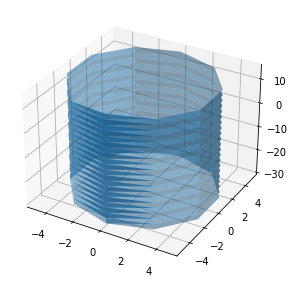

In [33]:
imat0    = 0; # couner for material
nn12     = 0; # global beam node12 counter
mesh_struc = []
mesh_aero = []
n_struc  = 0
n_surf   = 0
monopile = [Monopile()]

@dataclass
class FSISettings:
    data:List = field(default_factory=list)
simu_fsi = FSISettings()
if 'monopile' in data["components"].keys() and flag_foundation == 1:
    # creating structural mesh in DeSiO-Format
    if flag_foundation_struc == 1: 
        monopile[0].grid.struc.init_struc_params()
        X_R = np.hstack([ones((monopile_Struc.M+1,1))*cos_msl[0], \
                         ones((monopile_Struc.M+1,1))*cos_msl[1], \
                         ones((monopile_Struc.M+1,1))*cos_msl[2]])
        assert X_R.shape == (monopile_Struc.M+1,3), "X_R shape is wrong"
        monopile[0].grid.struc.X_RE         = monopile_Struc.arr_coordinates[:,:3] + X_R
        assert monopile[0].grid.struc.X_RE.shape[1] == 3, "X_RE shape is wrong"
        monopile[0].grid.struc.D1           = monopile_Struc.arr_coordinates[:,3:6]
        monopile[0].grid.struc.D2           = monopile_Struc.arr_coordinates[:,6:9]
        monopile[0].grid.struc.D3           = monopile_Struc.arr_coordinates[:,9:12]
        monopile[0].grid.struc.M            = monopile_Struc.M;
        monopile[0].grid.struc.connectivity = monopile_Struc.connectivity;

        monopile[0].grid.struc.matBeam.n_gl = nrb + nn12 + np.array(range(monopile_Struc.M + 1)) +1
        monopile[0].grid.struc.matBeam.inz  = np.array(range(monopile_Struc.M))
        monopile[0].grid.struc.matBeam.Cmat = monopile_Struc.arr_stiff_matrix;
        monopile[0].grid.struc.matBeam.mmat = monopile_Struc.arr_mass_matrix;
        monopile[0].grid.struc.matBeam.diss = monopile_Struc.dissipation;

        mesh_struc                             = fun_set_struc_mesh(mesh_struc,monopile)
        nmesh = len(mesh_struc)
        nmesh -= 1
        # last structure which was added named monopile
        mesh_struc[nmesh].strname = 'monopile';
        imat0                                  = mesh_struc[nmesh].imat;
        n_struc                                = n_struc + 1;
        nn12          = monopile[0].grid.struc.matBeam.n_gl[-1] - nrb;

    # creating aero grid in DeSiO-Format
    if flag_foundation_aero == 1: 
        monopile[0].grid.struc.init_aero_params()
        temp = ones(((monopile_Aero.M+1)*(2*monopile_Aero.N+1),1))
        X_R                             = np.hstack([temp * cos_msl[0], \
                                           temp * cos_msl[1], \
                                           temp * cos_msl[2]])
        monopile[0].grid.aero.X            = monopile_Aero.X_W + X_R;
        monopile[0].grid.aero.M            = monopile_Aero.M; 
        monopile[0].grid.aero.N = 2*monopile_Aero.N;
        monopile[0].grid.aero.connectivity = monopile_Aero.connectivity_w;

        mesh_aero = fun_set_aero_mesh(mesh_aero,monopile); 
        n_surf    = n_surf + 1
        
        fun_plot_3Dmesh('2D',mesh_aero);


    # set input for FSI
    if flag_foundation_aero == 1 and flag_foundation_struc == 1:
        simu_fsi.data.append(['beam',n_struc,n_surf, fsi_radius_rbf])


# print('mx=',vars(mesh_aero[0])['mx'],',my=',vars(mesh_aero[0])['my'],'nn=', vars(mesh_aero[0])['nn'])
# print(len(mesh_aero))

In [34]:
print(simu_fsi.data)

[['beam', 1, 1, 5.3]]


In [35]:
@dataclass
class Tower:
    """Class for keeping track of monopile mesh."""
    grid: Grid = Grid()

# Tower

fun_set_struc_mesh: nmesh = 1
fun_set_aero_mesh: nmesh = 1
mx= 10 ,my= 20 nn= 231
mx= 10 ,my= 50 nn= 561


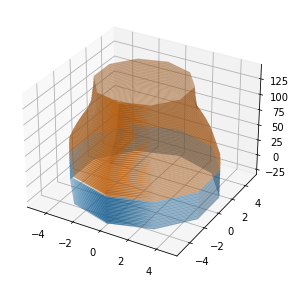

In [36]:
n_struc = len(mesh_struc)
n_surf  = len(mesh_aero)
tower = [deepcopy(Tower())];
if 'tower' in data["components"].keys() and flag_tower == 1:
    # creating structural mesh in DeSiO-Format
    if flag_tower_struc == 1: 
        tower[0].grid.struc.init_struc_params()
        temp = ones((tower_Struc.M+1,1))
        X_R         = np.hstack([temp * cos_msl[0], \
                                temp * cos_msl[1], \
                                temp * cos_msl[2]])

        tower[0].grid.struc.X_RE         = tower_Struc.arr_coordinates[:,:3] + X_R;
        tower[0].grid.struc.D1           = tower_Struc.arr_coordinates[:,3:6]
        tower[0].grid.struc.D2           = tower_Struc.arr_coordinates[:,6:9]
        tower[0].grid.struc.D3           = tower_Struc.arr_coordinates[:,9:12]
        tower[0].grid.struc.M            = tower_Struc.M;
        tower[0].grid.struc.connectivity = tower_Struc.connectivity;

        tower[0].grid.struc.matBeam.n_gl = nrb + nn12 + \
                                        np.array(range(tower_Struc.M + 1)) + 1
        tower[0].grid.struc.matBeam.inz  = np.array(range(tower_Struc.M ))
        tower[0].grid.struc.matBeam.Cmat = tower_Struc.arr_stiff_matrix;
        tower[0].grid.struc.matBeam.mmat = tower_Struc.arr_mass_matrix;
        tower[0].grid.struc.matBeam.diss = tower_Struc.dissipation;

        mesh_struc                             = fun_set_struc_mesh(mesh_struc,tower);
        nmesh = len(mesh_struc)
        nmesh -= 1
        mesh_struc[nmesh].strname = 'tower';
        imat0                                  = mesh_struc[nmesh].imat;
        n_struc                                = n_struc + 1;
        nn12          = tower[0].grid.struc.matBeam.n_gl[-1]-nrb;


    # creating aero grid in DeSiO-Format
    if flag_tower_aero == 1: 
        tower[0].grid.struc.init_aero_params()
        temp = ones(((tower_Aero.M+1)*(2*tower_Aero.N+1),1))
        X_R                             = np.hstack([temp * cos_msl[0], \
                                           temp * cos_msl[1], \
                                           temp * cos_msl[2]])
        tower[0].grid.aero.X            = tower_Aero.X_W + X_R;
        tower[0].grid.aero.M            = tower_Aero.M; 
        tower[0].grid.aero.N = 2*tower_Aero.N;
        tower[0].grid.aero.connectivity = tower_Aero.connectivity_w;

        mesh_aero = fun_set_aero_mesh(mesh_aero,tower); 
#         print('mx=',vars(mesh_aero[0])['mx'],',my=',vars(mesh_aero[0])['my'],'nn=', vars(mesh_aero[0])['nn'])
#         print('mx=',vars(mesh_aero[1])['mx'],',my=',vars(mesh_aero[1])['my'],'nn=', vars(mesh_aero[1])['nn'])
        n_surf    = n_surf + 1

        fun_plot_3Dmesh('2D',mesh_aero);

    # set input for FSI
    if flag_tower_aero == 1 and flag_tower_struc == 1:
        simu_fsi.data.append(['beam',n_struc,n_surf, fsi_radius_rbf])
print('mx=',vars(mesh_aero[0])['mx'],',my=',vars(mesh_aero[0])['my'],'nn=', vars(mesh_aero[0])['nn'])
print('mx=',vars(mesh_aero[1])['mx'],',my=',vars(mesh_aero[1])['my'],'nn=', vars(mesh_aero[1])['nn'])

In [37]:
print(simu_fsi.data)

[['beam', 1, 1, 5.3], ['beam', 2, 2, 5.3]]


# Blades

In [38]:
@dataclass
class RotorData:
    @dataclass
    class RotorDataAero:
        X_C:np.array = np.array([])
        X_W:np.array = np.array([])
    @dataclass
    class RotorDataStruc:
        X_RE:np.array = np.array([])
        D1:np.array = np.array([])
        D2:np.array = np.array([])
        D3:np.array = np.array([])
        matBeam:MatProp = MatProp()
    aero:RotorDataAero = RotorDataAero(  X_C = np.array([])
                         , X_W  = np.array([]))
    struc:RotorDataStruc = RotorDataStruc(X_RE = np.array([]), 
                            D1 = np.array([]), 
                            D2 = np.array([]), 
                            D3 = np.array([]),  
                            matBeam = MatProp())

In [39]:
def  fun_blades2rotor(blade_aero, blade_struc, n_pitch, a_pitch, n_rotor, a_rotor, n_tilt, a_tilt, x_r):
    # translating, pitching and rotating of blade to bring in rotor position
    # rotation matrix around pitch axis
    assert n_pitch.ndim == 2, "n_pitch must be 1x3"
    assert n_rotor.ndim == 2, "n_rotor must be 1x3"
    assert n_tilt.ndim == 2, "n_tilt must be 1x3"
    Rp = cos(a_pitch*pi/180)*eye(3) + \
        sin(a_pitch*pi/180)*skew(n_pitch)+\
            (1-cos(a_pitch*pi/180))*n_pitch.T@n_pitch
    # rotation matrix around rotor axis
    Rr = cos(a_rotor*pi/180)*eye(3) + \
        sin(a_rotor*pi/180)*skew(n_rotor)+\
            (1-cos(a_rotor*pi/180))*n_rotor.T @ n_rotor;
    # rotation matrix around tilt
    Rt = cos(a_tilt*pi/180)*eye(3) + \
        sin(a_tilt*pi/180)*skew(n_tilt)+\
            (1-cos(a_tilt*pi/180))*n_tilt.T @ n_tilt;

    # print(f'Rr = {Rr}')
    # print(f'Rp = {Rp}')
    # print(f'Rt = {Rt}')
    # calculate new position vector for aero grid in global cos
    nnodes = (blade_aero.M+1)*(blade_aero.N+1);
    temp = ones((nnodes,1))
    X_R = np.hstack([ temp * x_r[0],
                        temp * x_r[1],
                        temp * x_r[2]])
    blade_ro_cos = RotorData()
    blade_ro_cos.aero.X_C  = (Rt @ Rr @ (Rp @ blade_aero.X_C.T + X_R.T)).T

    nnodes = (blade_aero.M+1)*(2*blade_aero.N+1);
    temp = ones((nnodes,1))
    X_R = np.hstack([ temp * x_r[0],
                        temp * x_r[1],
                        temp * x_r[2]])
    blade_ro_cos.aero.X_W  = (Rt @ Rr @ (Rp @ blade_aero.X_W.T + X_R.T)).T

    nnodes = (blade_struc.M+1);
    temp = ones((nnodes,1))
    X_R = np.hstack([ temp * x_r[0],
                        temp * x_r[1],
                        temp * x_r[2]])
    
    blade_ro_cos.struc.X_RE = (Rt @ Rr @ \
                                (Rp @ blade_struc.arr_coordinates[:,:3].T \
                                     + X_R.T)).T
    blade_ro_cos.struc.D1 = (Rt @ Rr @ Rp @ \
                                blade_struc.arr_coordinates[:, 3:6].T).T
    blade_ro_cos.struc.D2 = (Rt @ Rr @ Rp @ \
                                blade_struc.arr_coordinates[:, 6:9].T).T
    blade_ro_cos.struc.D3 = (Rt @ Rr @ Rp @ \
                                blade_struc.arr_coordinates[:,9:12].T).T
    return blade_ro_cos

In [40]:
@dataclass
class WakeObj:
    inf:np.array = np.array([])
    nsurf:int = 0
    nsegments:int = 0
    nproperty:int = 0
@dataclass
class Wake:
    
    wakes:List[WakeObj] = field(default_factory=lambda: [WakeObj()])
    property:np.array = np.empty((1,2)) 
def   fun_blade_wake(wake, wakesurf, obj, tnrows, nrows):
    logging.info('inside fun_blade_wake')
    # define seperation edge
    if not wake:
        w = 0
        wake = Wake()
        logging.debug(f'wake was empty, creating new wake')
        logging.debug(f'wake index: w = {w}')
    else:
        w = len(wake.wakes)
        logging.debug(f'wake was not empty, appending new wake')
        logging.debug(f'wake index: w = {w}')
        wake.wakes.append(deepcopy(wake.wakes[0]))
        wake.property = np.append(wake.property, [[-1,-1]], axis=0)
        logging.debug(f'wake property.shape: {wake.property.shape}')
    
    
    
    a = 0;
    logging.debug(f'(obj.mx+1) = {obj.mx+1}')
    logging.debug(f'(obj.mx+1)*(obj.my+1)-1 = {(obj.mx+1)*(obj.my+1)-1}')
    logging.debug(f'obj.connectivity.shape = {obj.connectivity.shape}')
    logging.info('For loop started')
    iter_ = np.arange( (obj.mx+1)-1,(obj.mx+1)*(obj.my+1)-1, (obj.mx+1))
    wake.wakes[w].inf = np.zeros((len(iter_), 3))
    for j in iter_:
        
        logging.debug(f'j = {j}, j+(obj.mx+1) = {j+(obj.mx+1)}')
        row1, = np.nonzero(obj.connectivity[:,-1] == j)
        logging.debug(f'obj.connectivity[row1,:] = {obj.connectivity[row1,:]}')
        row2, = np.nonzero(obj.connectivity[row1,:].flatten() == j+(obj.mx+1))
        if not row2: 
            row2 = 0
        logging.debug(f'j= {j}, row1 = {row1}')
        logging.debug(f'j= {j}, row2 = {row2}')
        logging.debug(f'j= {j}, row1[row2] = {row1[row2]}')
        wake.wakes[w].inf[a,:] = np.array([j,j+obj.mx+1, row1[row2]]) 
        a = a + 1;
    
    logging.info('For loop ended')
    wake.wakes[w].nsurf     = wakesurf;
    wake.wakes[w].nsegments = a;
    wake.wakes[w].nproperty = w +1;

    # define wake properties
    wake.property[w,:2] = [tnrows,nrows];
    logging.info('fun_blade_wake done')
    return wake
# wake = []
# wake = fun_blade_wake(wake,
#                                     n_surf + len(blade_obj),
#                                     mesh_aero[n_surf + len(blade_obj)-1],
#                                     data["simulationparamter"]["nwakerows"],
#                                     data["simulationparamter"]["nwakerows"]);

In [41]:
class Helpers:
    def __init__(self):
        pass
    @staticmethod
    def hstack( temp, x_r):
        if x_r.ndim ==2:
            x_r = x_r.flatten()
        return np.hstack([ temp * x_r[0], \
                            temp * x_r[1], \
                                temp * x_r[2]])
utils = Helpers()

In [42]:
from copy import deepcopy
@dataclass
class Blade:
    """Class for blade data"""
    def __init__(self) -> None:
        struc = MeshInfo(M=0,
                         N=0,
                         connectivity=np.array([]))
        self.grid: Grid = Grid(struc=struc, aero=struc)
    def __repr__(self) -> str:
        return f"Blade: {self.grid}"

@dataclass
class BladeAero:
    X:np.array = np.array([])
    connectivity:np.array = np.array([])
    M:int = 0
    N:int = 0
@dataclass
class Blade2:

    @dataclass
    class BladeGrid:
        aero:BladeAero = BladeAero(X = np.array([]),
                                  connectivity = np.array([]),
                                  M = 0,
                                  N = 0)
    temp = BladeAero(X = np.array([]),
                                  connectivity = np.array([]),
                                  M = 0,
                                  N = 0)
    grid:BladeGrid = BladeGrid(aero = temp)

nbl = 0; imatb = imat0;
blades = [Blade() for i in range(n_blades)]
blade_obj = []
wake = []
if 'blade' in data["components"] and flag_blade == 1:
    ir1    = -i2 
    ir2    =  i1
    ir3    =  i3

    # Blade root and rest of the blade
    nn = 0; 
    ne = 0; 
    inz_blade_root = [];
    if blade_Aero.nbr != 0:
        # getting indices for extracting blade root from arrays
        arr_inz_airfoil = blade_Aero.arr_inz_airfoil;
        inz = np.nonzero(arr_inz_airfoil<=blade_Aero.nbr -1)[0]
        inz_blade_root = np.array(range(inz[-1]+2)) 

        M_br = len(inz_blade_root)-1;
        N_br = 2*blade_Aero.N;

        nn_br = (M_br+1)*(blade_Aero.N+1);
        ne_br = M_br*blade_Aero.N;
        for i  in range(n_blades):
            n_struc = len(mesh_struc);
            n_surf  = len(mesh_aero);

            # position angle of blade i in rotor
            alpha_blades = (i)*2*np.pi/n_blades*180/np.pi;

            # positioning blade in rotor
            blades[i].grid = fun_blades2rotor(blade_Aero, 
                                                blade_Struc, 
                                                ir3, 
                                                -pitch_angle, 
                                                ir2, 
                                                alpha_blades, 
                                                n_tilt, 
                                                uptilt_angle*180/pi, 
                                                [0,0,hub_diameter/2]); 


            
            # creating structural mesh in DeSiO-Format
            if flag_blade_struc == 1:
                nbl = blade_Struc.M+1;
                temp = ones((blade_Struc.M+1,1))
                X_R = np.hstack([temp * cos_hc[0,0],
                                temp * cos_hc[0,1],
                                temp * cos_hc[0,2]])


                blades[i].grid.struc.X_RE = blades[i].grid.struc.X_RE + X_R;
                blades[i].grid.struc.M = blade_Struc.M;
                blades[i].grid.struc.connectivity = blade_Struc.connectivity;
#                 print(f'nrb = {nrb}')
#                 print(f'nn12 = {nn12}')
#                 print(f'nbl = {nbl}')
#                 print(f'np.array(range(nbl)) = {np.array(range(nbl))}')
                blades[i].grid.struc.matBeam.n_gl = (nrb+1) + nn12 + \
                                                    (i)*nbl + np.array(range(nbl))
                blades[i].grid.struc.matBeam.inz  = np.array(range(blade_Struc.M))
                blades[i].grid.struc.matBeam.Cmat = blade_Struc.arr_stiff_matrix
                blades[i].grid.struc.matBeam.mmat = blade_Struc.arr_mass_matrix
                blades[i].grid.struc.matBeam.diss = blade_Struc.dissipation

                mesh_struc = fun_set_struc_mesh(mesh_struc,[blades[i]]);
                nmesh = len(mesh_struc)
                nmesh -= 1
                mesh_struc[nmesh].strname = 'blade ' + str(i)
                mesh_struc[nmesh].imat = imatb;

                n_struc = n_struc + 1;
                nbl = n_blades*nbl;

            
            # creating aero grid in DeSiO-Format
            if flag_blade_aero == 1:

                temp = ones(((blade_Aero.M+1)*(blade_Aero.N+1),1))
                X_R = utils.hstack(temp, cos_hc)
                
                X_C = blades[i].grid.aero.X_C  + X_R

                temp = ones(((blade_Aero.M+1)*(2*blade_Aero.N+1),1))
                X_R = utils.hstack(temp, cos_hc)
                X_W = blades[i].grid.aero.X_W  + X_R;

                # Blade root and rest of the blade
                if len(blade_obj)<2:
                    logging.info(f'i = {i},len(blade_obj) = {len(blade_obj)}')
                    # there are only two blades
                    blade_obj.append(deepcopy(Blade2()))
                if blade_Aero.nbr != 0:
                    #print(f'blade_obj[0].grid.aero.N = {blade_obj[0].grid.aero.N}')
                    # extracting blade root from arrays
                    blade_obj[0].grid.aero.N = N_br;
                    
                    blade_obj[0].grid.aero.M = M_br;
                    blade_obj[0].grid.aero.X = X_W[:(N_br+1)*(M_br+1),:]
                    blade_obj[0].grid.aero.connectivity = \
                                blade_Aero.connectivity_w[:M_br*N_br,:]

                    
                    if len(blade_obj)<2:
                        logging.info(f'i = {i},len(blade_obj) = {len(blade_obj)}')
                        # there are only two blades
                        blade_obj.append(deepcopy(Blade2()))
                    # extracting rest of blade from arrays
                    
                    blade_obj[1].grid.aero.N = blade_Aero.N;
                    blade_obj[1].grid.aero.M = blade_Aero.M-M_br;
#                     print('X_C=',X_C)
                    blade_obj[1].grid.aero.X = X_C[(nn_br-blade_Aero.N-1):,:]
                    blade_obj[1].grid.aero.connectivity = blade_Aero.connectivity_c[ne_br:,:]-(nn_br-blade_Aero.N)+1;
                else:
                    blade_obj[0].grid.aero.N = blade_Aero.N;
                    blade_obj[0].grid.aero.M = blade_Aero.M;
                    blade_obj[0].grid.aero.X = X_C;
                    blade_obj[0].grid.aero.connectivity = blade_Aero.connectivity_c;


                
                # creating mesh in DeSiO-Format
                print('mx=',vars(mesh_aero[0])['mx'],',my=',vars(mesh_aero[0])['my'],'nn=', vars(mesh_aero[0])['nn'])
                print('mx=',vars(mesh_aero[1])['mx'],',my=',vars(mesh_aero[1])['my'],'nn=', vars(mesh_aero[1])['nn'])
                
                mesh_aero = fun_set_aero_mesh(mesh_aero,blade_obj);
                print(f'len(mesh_aero) = {len(mesh_aero)}')
                for obj in mesh_aero:
                    if hasattr(obj, 'imat'):
                        # print(f'obj.__dict__ = {obj.__dict__}')
                        if 'imat' in obj.__dict__.keys():
                            delattr(obj,'imat')
                            # del obj.__dict__['imat']
                    if hasattr(obj, 'strname'):
                        if 'strname' in obj.__dict__.keys():
                            delattr(obj,'strname')
                            # del obj.__dict__['strname']
                
                # start troubleshooting from line 396 before that it's correct

                logging.debug('Inputs to fun_blade_wake')
                logging.debug(f'n_surf + len(blade_obj)= {n_surf + len(blade_obj)}')
                logging.debug(f'data["simulationparamter"]["nwakerows"] = {data["simulationparamter"]["nwakerows"]}')
                logging.debug(f'wake = {wake}')
                logging.debug(f'mesh_aero[n_surf + len(blade_obj)-1] = {mesh_aero[n_surf + len(blade_obj)-1]}')
                logging.debug('Inputs to fun_blade_wake end')
                wake = fun_blade_wake(wake,
                                    n_surf + len(blade_obj),
                                    mesh_aero[n_surf + len(blade_obj)-1],
                                    data["simulationparamter"]["nwakerows"],
                                    data["simulationparamter"]["nwakerows"]);
                

            
            # setting input for FSI
            if flag_blade_aero == 1 and flag_blade_struc == 1:
                logging.debug('Setting input for FSI')
                logging.debug(f'len(blade_obj) = {len(blade_obj)}')
                for j in range(len(blade_obj)):
                    simu_fsi.data.append(['beam',n_struc,n_surf+j+1, fsi_radius_rbf])
                    

logging.debug(f'len(simu_fsi.data) = {len(simu_fsi.data)}')
logging.debug(f'simu_fsi.data = {simu_fsi.data}')


fun_set_struc_mesh: nmesh = 2
mx= 10 ,my= 20 nn= 231
mx= 10 ,my= 50 nn= 561
fun_set_aero_mesh: nmesh = 2
len(mesh_aero) = 4
fun_set_struc_mesh: nmesh = 3
mx= 10 ,my= 20 nn= 231
mx= 10 ,my= 50 nn= 561
fun_set_aero_mesh: nmesh = 4
len(mesh_aero) = 6
fun_set_struc_mesh: nmesh = 4
mx= 10 ,my= 20 nn= 231
mx= 10 ,my= 50 nn= 561
fun_set_aero_mesh: nmesh = 6
len(mesh_aero) = 8


# Additional Masses

8
[['beam', 1, 1, 5.3], ['beam', 2, 2, 5.3], ['beam', 3, 3, 5.3], ['beam', 3, 4, 5.3], ['beam', 4, 5, 5.3], ['beam', 4, 6, 5.3], ['beam', 5, 7, 5.3], ['beam', 5, 8, 5.3]]


# # start troubleshooting from line 416 before that it's correct

In [44]:
print(vars(mesh_aero[3]))

{'mx': 5, 'nn': 258, 'connectivity': array([[  7,   6,   0,   1],
       [  8,   7,   1,   2],
       [  9,   8,   2,   3],
       [ 10,   9,   3,   4],
       [ 11,  10,   4,   5],
       [ 13,  12,   6,   7],
       [ 14,  13,   7,   8],
       [ 15,  14,   8,   9],
       [ 16,  15,   9,  10],
       [ 17,  16,  10,  11],
       [ 19,  18,  12,  13],
       [ 20,  19,  13,  14],
       [ 21,  20,  14,  15],
       [ 22,  21,  15,  16],
       [ 23,  22,  16,  17],
       [ 25,  24,  18,  19],
       [ 26,  25,  19,  20],
       [ 27,  26,  20,  21],
       [ 28,  27,  21,  22],
       [ 29,  28,  22,  23],
       [ 31,  30,  24,  25],
       [ 32,  31,  25,  26],
       [ 33,  32,  26,  27],
       [ 34,  33,  27,  28],
       [ 35,  34,  28,  29],
       [ 37,  36,  30,  31],
       [ 38,  37,  31,  32],
       [ 39,  38,  32,  33],
       [ 40,  39,  33,  34],
       [ 41,  40,  34,  35],
       [ 43,  42,  36,  37],
       [ 44,  43,  37,  38],
       [ 45,  44,  38,  39],
      

In [45]:
for i,obj in enumerate(mesh_struc):
    print(f"i = {i+1}, mesh_struc[{i}]: nn ={obj.nn}, mx = {obj.mx}")

i = 1, mesh_struc[0]: nn =21, mx = 20
i = 2, mesh_struc[1]: nn =51, mx = 50
i = 3, mesh_struc[2]: nn =51, mx = 50
i = 4, mesh_struc[3]: nn =51, mx = 50
i = 5, mesh_struc[4]: nn =51, mx = 50


In [46]:
N_br

10